In [170]:
#all imports for this workbook

import numpy as np
import pandas as pd
import time

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 
%config InlineBackend.figure_format='retina'

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('dark')

#for choropleth maps
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.io as pio
# plotly.tools.set_credentials_file(username='dwan1545', api_key='5l38gLdHHXTIuQRbPeTh')
plotly.offline.init_notebook_mode(connected=True)

In [171]:
from cycler import cycler
# Update matplotlib defaults to something nicer, including the tableau 20 colormap 
mpl_update = {'font.size':16,
              'xtick.labelsize':14,
              'ytick.labelsize':14,
              'figure.figsize':[16,9],
              'axes.labelsize':20,
#               'axes.labelcolor':'#677385',
              'axes.titlesize':20,
              'lines.color':'#0055A7',
              'lines.linewidth':3,
#               'text.color':'#677385',
              'axes.prop_cycle': cycler('color', ['#1f77b4','#aec7e8','#ff7f0e','#ffbb78','#2ca02c',
                                                  '#98df8a','#d62728','#ff9896','#9467bd','#c5b0d5',
                                                  '#8c564b','#c49c94','#e377c2','#f7b6d2','#7f7f7f',
                                                  '#c7c7c7','#bcbd22','#dbdb8d','#17becf','#9edae5'])
             }
mpl.rcParams.update(mpl_update)

In [172]:
#change these paths as necessary
data_path = '/Users/dhawan/Documents/K2/exploratory_analysis/health_project/data/rawLLCP2017.XPT'
hdf_path = '/Users/dhawan/Documents/K2/exploratory_analysis/health_project/data/interim/brfss.h5'

# Explore Data

In this notebook, we'll explore relations between the target variables and the demographic/environmental variables. We'll first load the cleaned data set we built in the last notebook.

In [173]:
# If data not yet loaded
%time df = pd.read_hdf(hdf_path, 'clean_17')

CPU times: user 269 ms, sys: 152 ms, total: 421 ms
Wall time: 469 ms


In [174]:
#let's take a look
pd.options.display.max_columns=100
df.head()

sex  age  marital    education employment   income    state  \
0  female  >65  widowed      college    retired     <50k  Alabama   
1    male  >65  married      college    retired     >75k  Alabama   
2    male  >65  married   elementary    retired  unknown  Alabama   
3  female  >65  widowed  high_school    retired     <10k  Alabama   
4  female  >65  widowed   elementary     unable     <15k  Alabama   

  emotional_support satisfied_life cannot_pay_bills safe_living  \
0           unknown        unknown          unknown     unknown   
1           unknown        unknown          unknown     unknown   
2           unknown        unknown          unknown     unknown   
3           unknown        unknown          unknown     unknown   
4           unknown        unknown          unknown     unknown   

  cannot_afford_meals finances   stress depression times_moved_bins  \
0             unknown  unknown  unknown         no          unknown   
1             unknown  unknown  unknown         no          unknown   
2             unknown  unknown  unknown         no          unknown   
3             unknown  unknown  unknown        yes          unknown   
4             unknown  unknown  unknown         no          unknown   

  poor_mental_health_days   smoke_now    ecig_now  avg_drinks  many_drinks  \
0                       0  not_at_all  not_at_all           0            0   
1                       0  not_at_all  not_at_all           0            0   
2                       0  not_at_all  not_at_all           1            0   
3                       0  not_at_all  not_at_all           0            0   
4                       0  not_at_all  not_at_all           0            0   

   max_drinks marijuana_purpose  marijuana_pleasure_days  _llcpwt  
0           0           unknown                       -1       79  
1           0           unknown                       -1       89  
2           1           unknown                       -1      440  
3           0           unknown                       -1      194  
4           0           unknown                       -1      169

### Target x Demographic

Let's take a look at differences in target variables across demographic variables. The following functions will help us analyze the categorical target variables (e.g., smoke_now and marijuana_purpose).

In [175]:
#let's create a function to help us analyze the categorical target variables against the demo/env. variables

def analyze_cat_cat(df, var, target):
    """
    Returns a dataframe that crosstabs the target against var,
    after dropping 'unknown' values. Returns both absolute values
    as well as proportions within each group of var.
    
    df is the dataframe containing all the variables
    var is a string identifying the exogenous variable
    target is a string identifying the endogenous variable
    """

    results = df.groupby([var, target]) \
                .agg( {target: 'count'}) \
                .rename({target: 'N'}, axis=1) \
                .drop('unknown', axis=0, level=0, errors='ignore') \
                .drop('unknown', axis=0, level=1, errors='ignore')
    
    results['percent'] = results.groupby(level=0) \
                                .apply(lambda x: x / x.sum())
    
    return results

In [176]:
#let's define a helper function to plot a nice chart
def plot_cat_target(series, ax, max_x=0.2, xerr=None):
    """Plots the target variable for each group in series on a horizontal bar chart.
    Includes several modifications to make the graph look good.
    Plots the chart on ax with max xlim of max_x and errorbars xerr (optional).
    """
    if xerr is None: series.plot.barh(stacked=True, ax=ax, color=(0.2, 0.4, 0.6, 0.6))
    else: series.plot.barh(stacked=True, ax=ax, color=(0.2, 0.4, 0.6, 0.6), xerr=xerr)
#     ax.set_xlabel('Proportion of Respondents', fontsize=15)
    ax.set_xlim(0, max_x)
    ax.get_xaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x,p: str(int(x*100))+'%'))   #format the x-axis to percentages

    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.annotate('{:.1f} %'.format(width*100), (p.get_x()+1.05*width, p.get_y()+.4*height), 
                    fontsize=15, fontweight='bold')

Now let's cycle through the variables and plot the targets against them. We'll also convert some of the varibles into categoricals to make sure they're plotted in the right order.

In [177]:
#create categories to make sure bar chart is ordered correctly
df['education'] = pd.Categorical(df['education'], categories=['unknown', 'no_school', 'elementary',
                                'high_school', 'college'], ordered=True)
df['marital'] = pd.Categorical(df['marital'], categories=['unknown', 'never_married', 'married',
                                'separated', 'divorced', 'widowed'], ordered=True)
df['employment'] = pd.Categorical(df['employment'], categories=['unknown', 'student', 'homemaker',
                                'employed', 'unemployed', 'unable', 'retired'], ordered=True)
df['emotional_support'] = pd.Categorical(df['emotional_support'], categories=['unknown', 'never', 'rarely',
                                'sometimes', 'usually', 'always'], ordered=True)
df['satisfied_life'] = pd.Categorical(df['satisfied_life'], categories=['unknown', 'very_dissatisfied', 'dissatisfied',
                                'satisfied', 'very_satisfied'], ordered=True)
df['safe_living'] = pd.Categorical(df['safe_living'], categories=['unknown', 'extremely_unsafe', 'unsafe',
                                'safe', 'extremely_safe'], ordered=True)
df['cannot_afford_meals'] = pd.Categorical(df['cannot_afford_meals'], categories=['unknown', 'never_true', 'sometimes_true',
                                'often_true'], ordered=True)
df['finances'] = pd.Categorical(df['finances'], categories=['unknown', 'not_enough_money', 'just_enough_money',
                                'some_money_left'], ordered=True)
df['stress'] = pd.Categorical(df['stress'], categories=['unknown', 'none', 'a_little', 'some_of_time',
                                'most_of_time', 'all_of_time'], ordered=True)
df['poor_mental_health_days'] = pd.Categorical(df['poor_mental_health_days'], categories=['unknown', '0', '<5', '<10',
                                '<20', '>20'], ordered=True)

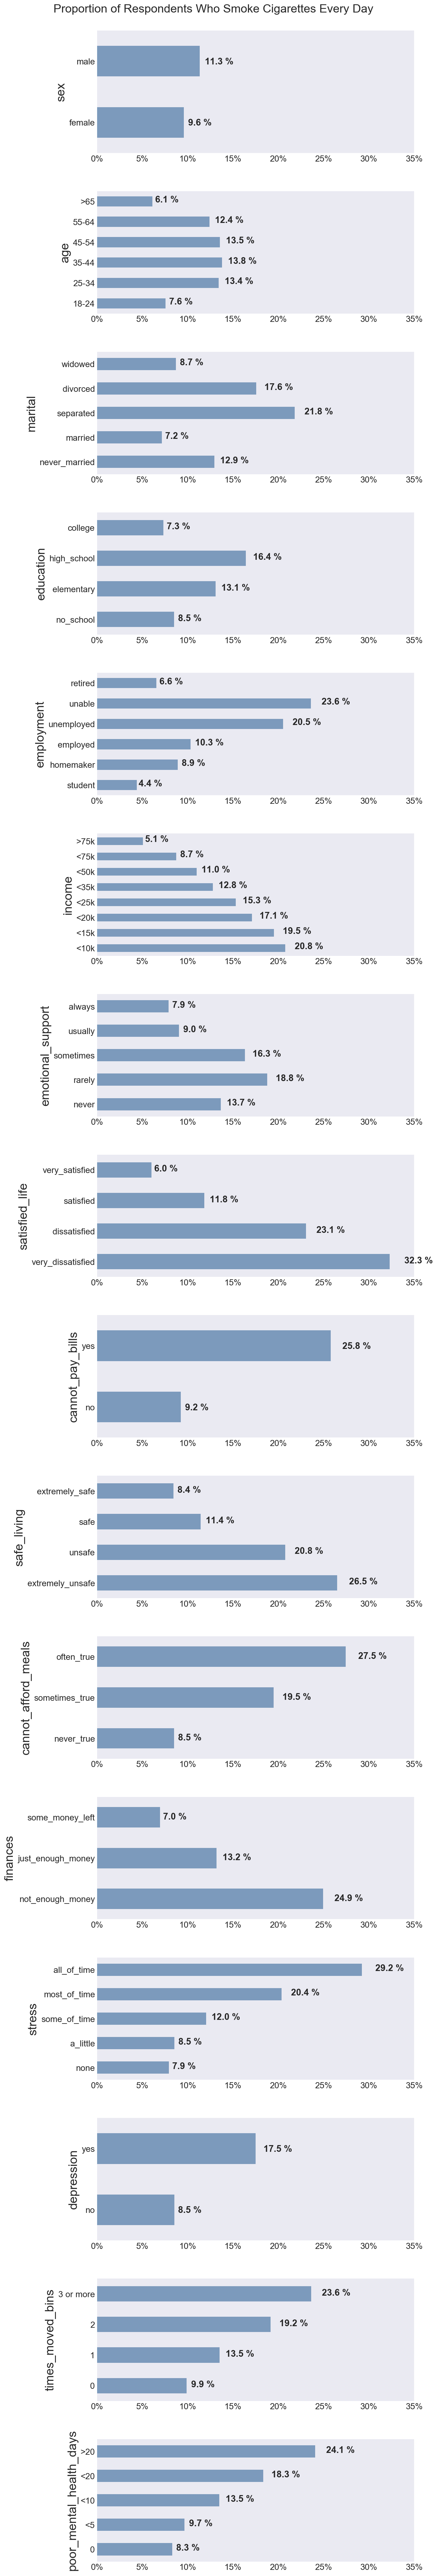

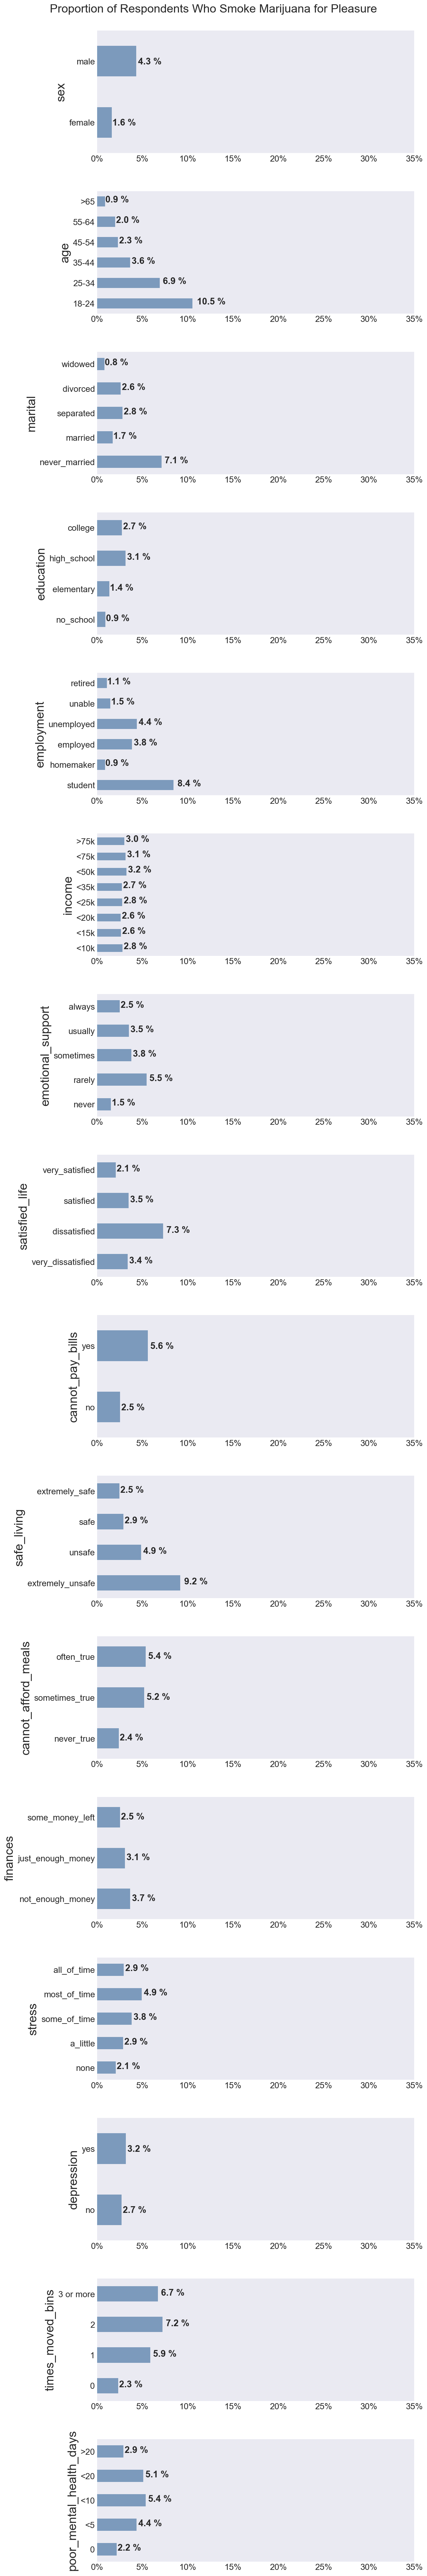

In [84]:
x_var = ['sex', 'age', 'marital', 'education', 'employment', 'income', 'emotional_support', 
         'satisfied_life', 'cannot_pay_bills', 'safe_living', 'cannot_afford_meals', 'finances', 'stress',
        'depression', 'times_moved_bins', 'poor_mental_health_days']

# plot Cigarette use against demographic and environmental variables
fig, ax = plt.subplots(16,1,figsize=(10,60))
y = 'smoke_now'
for j in range(len(x_var)):
    x = x_var[j]
    r = analyze_cat_cat(df, x, y)
    r = r['percent'].unstack()['every_day'] # re-orient and isolate value in dataframe
    plot_cat_target(r, ax[j], max_x=.35)
fig.suptitle('Proportion of Respondents Who Smoke Cigarettes Every Day', y=.98)
fig.tight_layout()
fig.subplots_adjust(top=.97)
fname = 'figures/smoke_cig_demo_2017.png'
fig.savefig(fname, format='png')

# plot marijuana use against demographic and environmental variables
fig, ax = plt.subplots(16,1,figsize=(10,60))
y = 'marijuana_purpose'
for j in range(len(x_var)):
    x = x_var[j]
    row= j // 2
    col = j % 2
    r = analyze_cat_cat(df, x, y)
    r = r['percent'].unstack()['pleasure'] # re-orient and isolate value in dataframe
    plot_cat_target(r, ax[j], max_x=.35)
fig.suptitle('Proportion of Respondents Who Smoke Marijuana for Pleasure', y=.98)
fig.tight_layout()
fig.subplots_adjust(top=.97)
fname = 'figures/marijuana_demo_2017.png'
fig.savefig(fname, format='png')

In [93]:
df.head()

sex  age  marital    education employment   income    state  \
0  female  >65  widowed      college    retired     <50k  Alabama   
1    male  >65  married      college    retired     >75k  Alabama   
2    male  >65  married   elementary    retired  unknown  Alabama   
3  female  >65  widowed  high_school    retired     <10k  Alabama   
4  female  >65  widowed   elementary     unable     <15k  Alabama   

  emotional_support satisfied_life cannot_pay_bills safe_living  \
0           unknown        unknown          unknown     unknown   
1           unknown        unknown          unknown     unknown   
2           unknown        unknown          unknown     unknown   
3           unknown        unknown          unknown     unknown   
4           unknown        unknown          unknown     unknown   

  cannot_afford_meals finances   stress depression times_moved_bins  \
0             unknown  unknown  unknown         no          unknown   
1             unknown  unknown  unknown         no          unknown   
2             unknown  unknown  unknown         no          unknown   
3             unknown  unknown  unknown        yes          unknown   
4             unknown  unknown  unknown         no          unknown   

  poor_mental_health_days   smoke_now    ecig_now  avg_drinks  many_drinks  \
0                       0  not_at_all  not_at_all           0            0   
1                       0  not_at_all  not_at_all           0            0   
2                       0  not_at_all  not_at_all           1            0   
3                       0  not_at_all  not_at_all           0            0   
4                       0  not_at_all  not_at_all           0            0   

   max_drinks marijuana_purpose  marijuana_pleasure_days state_code  
0           0           unknown                       -1         AL  
1           0           unknown                       -1         AL  
2           1           unknown                       -1         AL  
3           0           unknown                       -1         AL  
4           0           unknown                       -1         AL

Now let's take a look at the numerical target variables, including avg_drinks, many_drinks, max_drinks, and marijuana_pleasure_days.

In [122]:
#let's create a function to help us analyze the numerical target variables against the demo/env. variables

def analyze_cat_num(df, var, target):
    """
    Returns a dataframe that returns descriptive statistics for the 
    numerical target against var, after dropping 'unknown' values. 
    
    df is the dataframe containing all the variables
    var is a string identifying the exogenous variable
    target is a string identifying the endogenous variable
    """
    
    results = df.loc[~(df[target]==-1), [var, target]] \
                .groupby(var) \
                .describe() \
                .drop('unknown', axis=0, errors='ignore')
    
    results.columns = results.columns.droplevel()
    results['std_err'] = results['std'] / np.sqrt(results['count'])
    
    return results

In [158]:
#let's define a helper function to plot a nice chart
def plot_num_target(series, ax, max_x=0.2, xerr=None, xlabel=None):
    """Plots the target variable for each group in series on a horizontal bar chart.
    Includes several modifications to make the graph look good.
    Plots the chart on ax with max xlim of max_x and errorbars xerr (optional).
    """
    if xerr is None: series.plot.barh(stacked=True, ax=ax, color=(0.2, 0.4, 0.6, 0.6))
    else: series.plot.barh(stacked=True, ax=ax, color=(0.2, 0.4, 0.6, 0.6), xerr=xerr)
    if xlabel is not None: ax.set_xlabel(xlabel, fontsize=15)
    ax.set_xlim(0, max_x)

    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.annotate('{:.2f}'.format(width), (p.get_x()+1.05*width, p.get_y()+.8*height), 
                    fontsize=15, fontweight='bold')

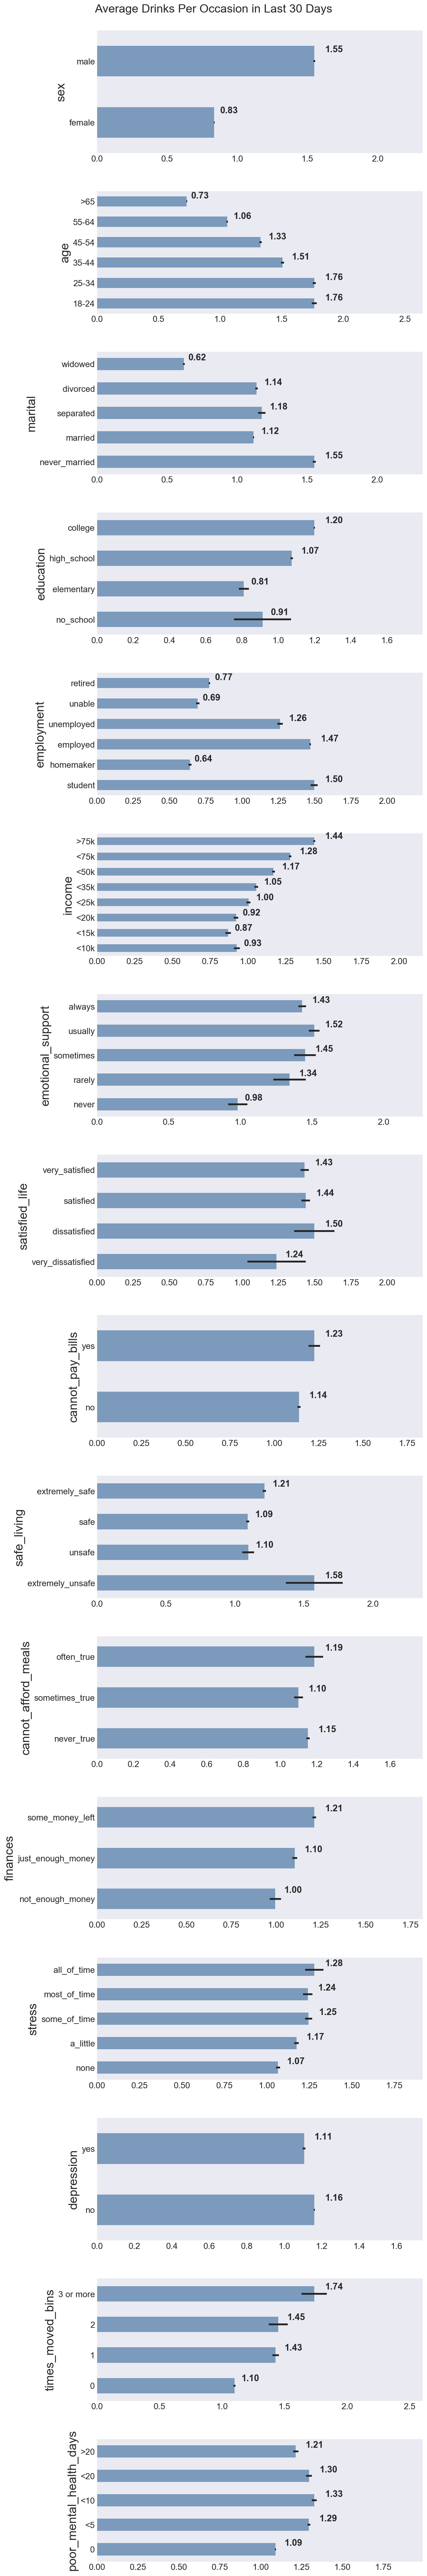

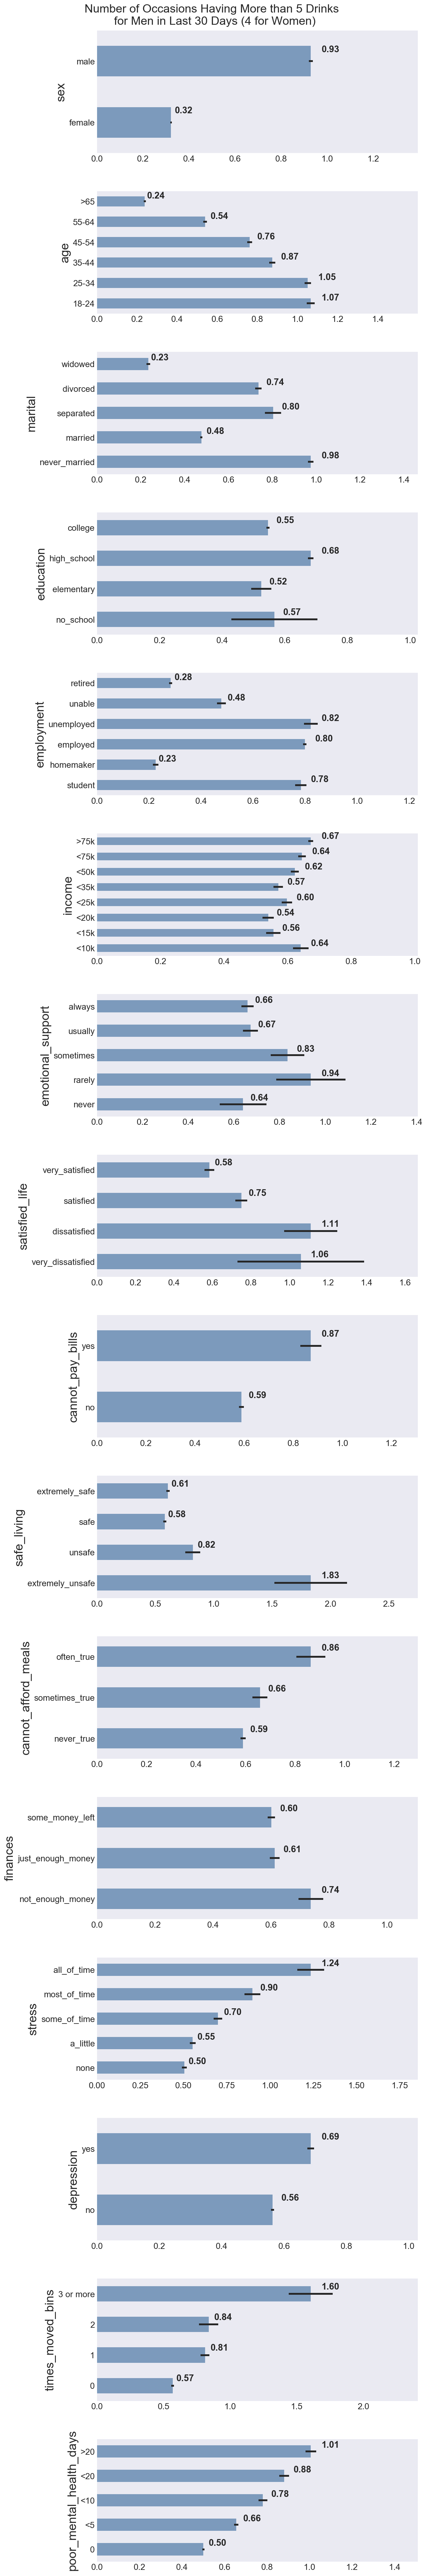

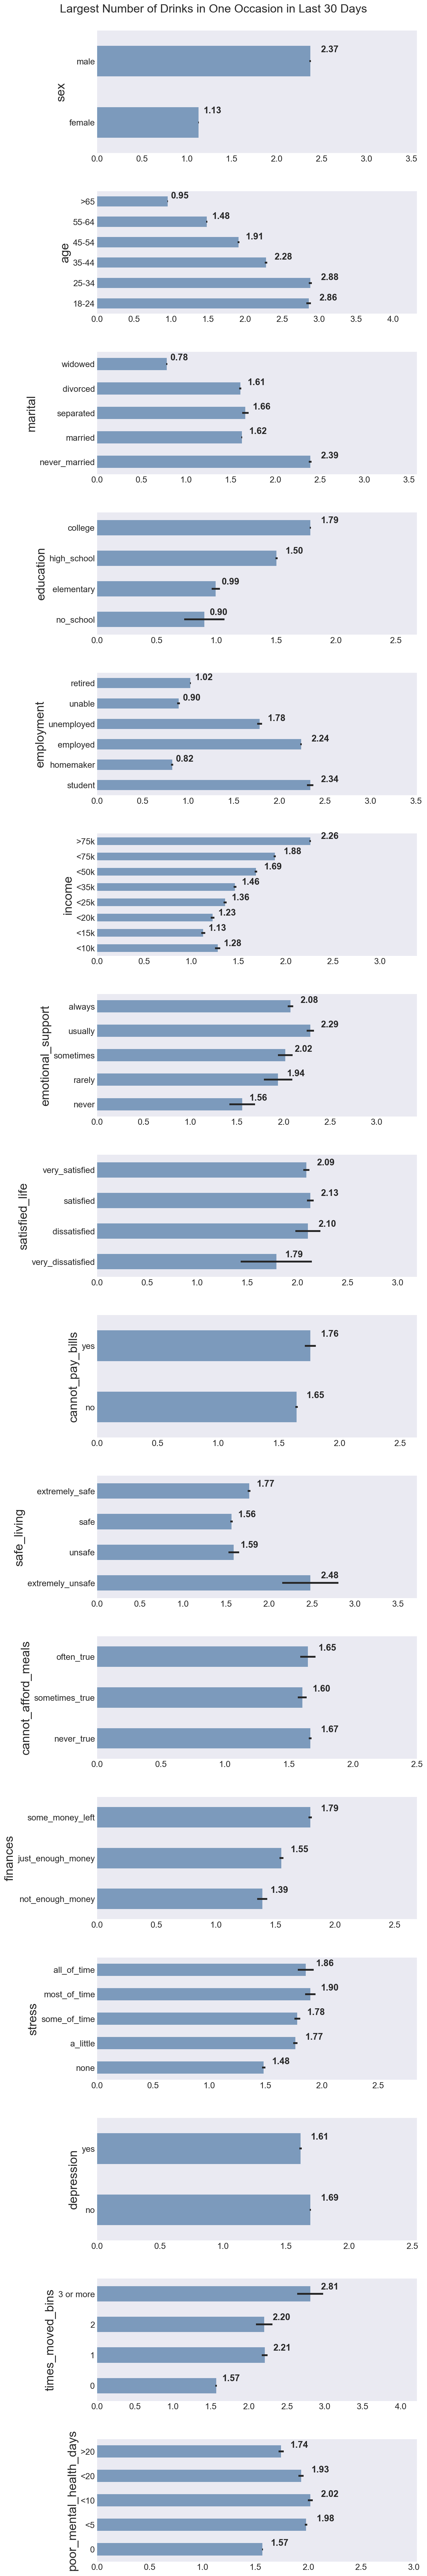

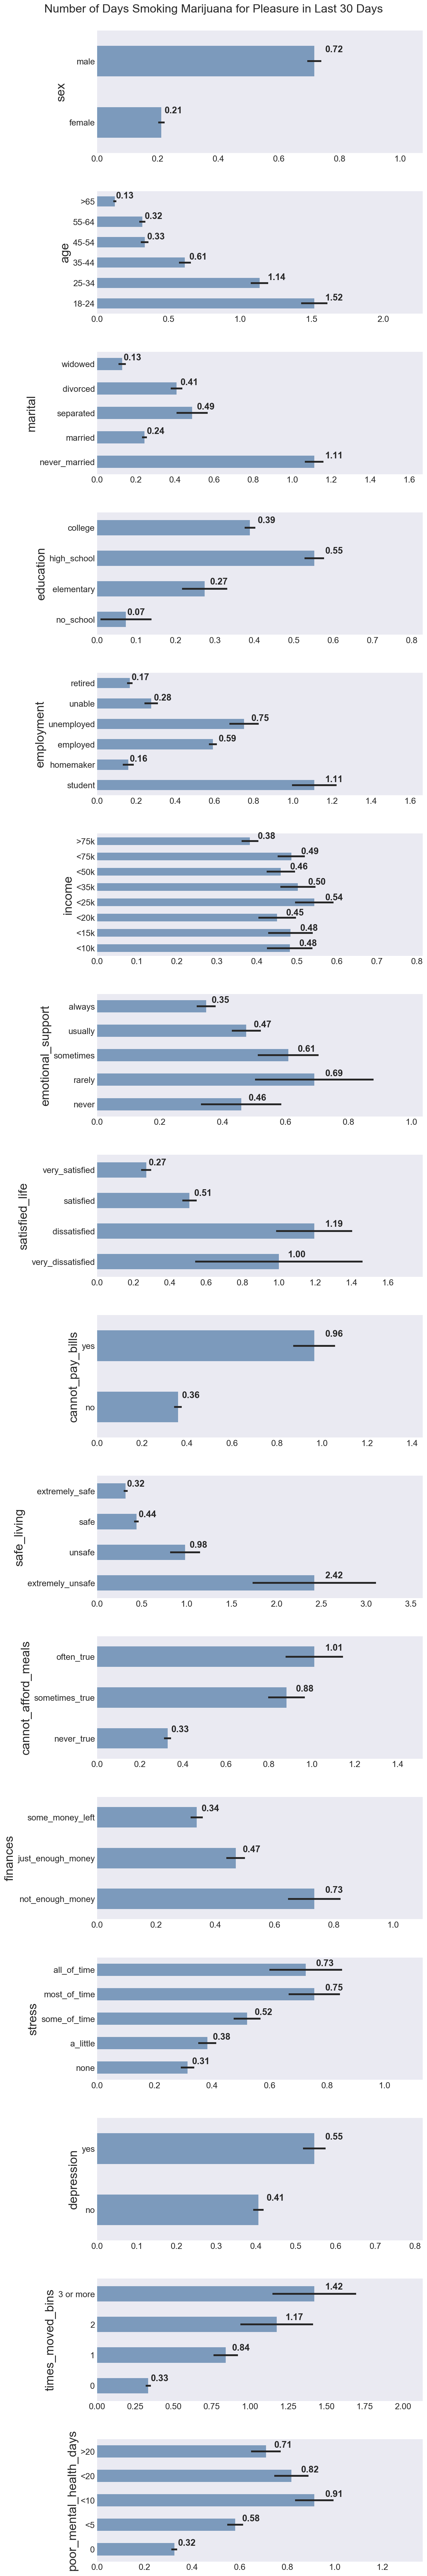

In [161]:
# plot avg_drinks against demographic and environmental variables
fig, ax = plt.subplots(16,1,figsize=(10,60))
y = 'avg_drinks'
label = 'Average Drinks Per Occasion in Last 30 Days'
fname = 'figures/avg_drinks_demo_2017.png'
for j in range(len(x_var)):
    x = x_var[j]
    x = analyze_cat_num(df, x, y)
    plot_num_target(x['mean'], ax[j], max_x=x['mean'].max()*1.5, xerr=x['std_err'])
fig.suptitle(label, y=.98)
fig.tight_layout()
fig.subplots_adjust(top=.97)
fig.savefig(fname, format='png')

# plot many_drinks against demographic and environmental variables
fig, ax = plt.subplots(16,1,figsize=(10,60))
y = 'many_drinks'
label = 'Number of Occasions Having More than 5 Drinks \n for Men (4 for Women) in Last 30 Days'
fname = 'figures/many_drinks_demo_2017.png'
for j in range(len(x_var)):
    x = x_var[j]
    x = analyze_cat_num(df, x, y)
    plot_num_target(x['mean'], ax[j], max_x=x['mean'].max()*1.5, xerr=x['std_err'])
fig.suptitle(label, y=.98)
fig.tight_layout()
fig.subplots_adjust(top=.97)
fig.savefig(fname, format='png')

# plot avg_drinks against demographic and environmental variables
fig, ax = plt.subplots(16,1,figsize=(10,60))
y = 'max_drinks'
label = 'Largest Number of Drinks in One Occasion in Last 30 Days'
fname = 'figures/max_drinks_demo_2017.png'
for j in range(len(x_var)):
    x = x_var[j]
    x = analyze_cat_num(df, x, y)
    plot_num_target(x['mean'], ax[j], max_x=x['mean'].max()*1.5, xerr=x['std_err'])
fig.suptitle(label, y=.98)
fig.tight_layout()
fig.subplots_adjust(top=.97)
fig.savefig(fname, format='png')

# plot avg_drinks against demographic and environmental variables
fig, ax = plt.subplots(16,1,figsize=(10,60))
y = 'marijuana_pleasure_days'
label = 'Number of Days Smoking Marijuana for Pleasure in Last 30 Days'
fname = 'figures/mj_pleasure_demo_2017.png'
for j in range(len(x_var)):
    x = x_var[j]
    x = analyze_cat_num(df, x, y)
    plot_num_target(x['mean'], ax[j], max_x=x['mean'].max()*1.5, xerr=x['std_err'])
fig.suptitle(label, y=.98)
fig.tight_layout()
fig.subplots_adjust(top=.97)
fig.savefig(fname, format='png')

### Target x State

Let's take a look at the proportion of people who smoke every day by state using the Choropleth library in plotly. First, we'll add a column for 2-letter state abbreviations to make it compatible with the library.

In [85]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    'District of Columbia': 'DC',
    'Puerto Rico': 'PR',
    'Guam': 'GU'
}

In [86]:
#apply the state map
df['state_code'] = df.state.map(us_state_abbrev)

In [87]:
results_state = analyze_cat_cat(df, 'state_code', 'smoke_now')

In [88]:
#color scale for choropleth map
scl = [
    [0.0, 'rgb(242,240,247)'],
    [0.2, 'rgb(218,218,235)'],
    [0.4, 'rgb(188,189,220)'],
    [0.6, 'rgb(158,154,200)'],
    [0.8, 'rgb(117,107,177)'],
    [1.0, 'rgb(84,39,143)']
]

#create choropleth object
go.Choropleth()
data = [go.Choropleth(
    colorscale = scl,
    autocolorscale = False,
    locations = results_state.index.levels[0],
    z = results_state['percent'].loc[:, 'every_day'],
    locationmode = 'USA-states',
    text = results_state.index.levels[0],
    marker = go.choropleth.Marker(
        line = go.choropleth.marker.Line(
            color = 'rgb(255,255,255)',
            width = 2
        )),
    colorbar = go.choropleth.ColorBar(
        title = "Proportion of Population<br> Smoking Every Day")
)]

#create layout for map
layout = go.Layout(
    title = go.layout.Title(
        text = '2017 Proportion of Population Who Smoke Cigarettes Every Day'
    ),
    geo = go.layout.Geo(
        scope = 'usa',
        projection = go.layout.geo.Projection(type = 'albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)'),
    width=1000,
    height=500
)

#plot and save map
fig = go.Figure(data = data, layout = layout)
plotly.offline.iplot(fig, filename = 'smoke_state_2017.png')
pio.write_image(fig, file='figures/smoke_state_2017.png', format='png')

In [169]:
results_state = analyze_cat_num(df, 'state_code', 'avg_drinks')

#create choropleth object
go.Choropleth()
data = [go.Choropleth(
    colorscale = scl,
    autocolorscale = False,
    locations = results_state.index,
    z = results_state['mean'],
    locationmode = 'USA-states',
    text = results_state.index,
    marker = go.choropleth.Marker(
        line = go.choropleth.marker.Line(
            color = 'rgb(255,255,255)',
            width = 2
        )),
    colorbar = go.choropleth.ColorBar(
        title = "Average Number of Drinks Per Occasion")
)]

#create layout for map
layout = go.Layout(
    title = go.layout.Title(
        text = 'Average Number of Drinks Per Occasion in 2017'
    ),
    geo = go.layout.Geo(
        scope = 'usa',
        projection = go.layout.geo.Projection(type = 'albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)'),
    width=1000,
    height=500
)

#plot and save map
fig = go.Figure(data = data, layout = layout)
plotly.offline.iplot(fig, filename = 'avg_drinks_state_2017.png')
pio.write_image(fig, file='figures/avg_drinks_state_2017.png', format='png')

### Statistical Tests of Independence

Now we will use the chi-square test of indepedence to identify statistically significant relation between demographic/ environmental variables and the target variables. This is meant as support for some of the graphs we have already seen.

In [216]:
import scipy as sp

In [233]:
#calculate chi-square for smoke_now against demo/env variables
y = df.smoke_now
weights = df._llcpwt
for var in x_var:
    x = df[var]
    contingency = pd.crosstab(x,y) \
                    .drop('unknown', axis=0, errors='ignore') \
                    .drop('unknown', axis=1, errors='ignore')
    chi2, p, dof, ex = sp.stats.chi2_contingency(contingency)
    sig = (p*2) < .05
    print("{}: Variable: {}, CHI: {}, p: {}".format(sig, var, chi2, p))

True: Variable: sex, CHI: 600.5496612271912, p: 3.9110918033977846e-131
True: Variable: age, CHI: 8579.653170289524, p: 0.0
True: Variable: marital, CHI: 11910.490097155662, p: 0.0
True: Variable: education, CHI: 536.2284770711095, p: 1.3131521168615676e-112
True: Variable: employment, CHI: 9459.184584151815, p: 0.0
True: Variable: income, CHI: 13817.498770013193, p: 0.0
True: Variable: emotional_support, CHI: 282.47664255227943, p: 2.1975549083179795e-56
True: Variable: satisfied_life, CHI: 585.6965756995381, p: 2.8367816902002355e-123
True: Variable: cannot_pay_bills, CHI: 2738.2316081015156, p: 0.0
True: Variable: safe_living, CHI: 901.0547627649277, p: 2.2222076451478347e-191
True: Variable: cannot_afford_meals, CHI: 3437.3271543999317, p: 0.0
True: Variable: finances, CHI: 3303.175911054857, p: 0.0
True: Variable: stress, CHI: 3255.1312974977413, p: 0.0
True: Variable: depression, CHI: 7903.0518877663635, p: 0.0
True: Variable: times_moved_bins, CHI: 670.6984341296169, p: 1.294911

In [234]:
#calculate chi-square for marijuana_purpose against demo/env variables
y = df.marijuana_purpose
weights = df._llcpwt
for var in x_var:
    x = df[var]
    contingency = pd.crosstab(x,y) \
                    .drop('unknown', axis=0, errors='ignore') \
                    .drop('unknown', axis=1, errors='ignore')
    chi2, p, dof, ex = sp.stats.chi2_contingency(contingency)
    sig = (p*2) < .05
    print("{}: Variable: {}, CHI: {}, p: {}".format(sig, var, chi2, p))

True: Variable: sex, CHI: 608.9872588105497, p: 1.13514811728537e-131
True: Variable: age, CHI: 2242.6674986263597, p: 0.0
True: Variable: marital, CHI: 1446.527638678111, p: 1.2906999982098132e-302
True: Variable: education, CHI: 30.284669953908015, p: 0.00039236992111637783
True: Variable: employment, CHI: 646.3826433475461, p: 4.874646604759684e-128
True: Variable: income, CHI: 218.36748293914383, p: 8.499534647661261e-35
True: Variable: emotional_support, CHI: 152.46389365226608, p: 1.7924072105623534e-26
True: Variable: satisfied_life, CHI: 302.10760322115317, p: 9.323874982622325e-60
True: Variable: cannot_pay_bills, CHI: 505.87661042127775, p: 2.541605339396012e-109
True: Variable: safe_living, CHI: 147.78062110661853, p: 2.5411746520938667e-27
True: Variable: cannot_afford_meals, CHI: 581.9112248146829, p: 1.8586251467069598e-122
True: Variable: finances, CHI: 435.0013613198193, p: 8.289708675101401e-91
True: Variable: stress, CHI: 679.1936468983948, p: 1.2503536927737028e-137


Interestingly, the chi-square test suggests that we can reject the null hypothesis that each of our demographic and environmental variables is independent with smoking frequency and marijuana purpose. In other words, there are signficiant differences in smoking frequency and marijuana usage purpose across all of these variables...

Let's use pairwise tukey tables to do a similar set of tests for our numerical target variables - average drinks, binge drinking, max number of drinks, and number of days using marijuana for pleasure. We will store these in a text file since there will be many tables. The tables will explore the null hypothesis that the means of target variables are not different within each demographic and environmental variable. 

In [290]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

targets=['avg_drinks', 'many_drinks', 'max_drinks', 'marijuana_pleasure_days']

for y in targets:
    summary={} #store tables in dict
    fname = 'figures/statistics/tukey_'+y+'.txt'
    for x in x_var:
        data = df.loc[(df[y]!=-1) & (df[x]!='unknown'), [x, y]]

        tukey = pairwise_tukeyhsd(endog=data[y],     # Data
                                  groups=data[x],   # Groups
                                  alpha=0.05)          # Significance level

        summary[x] = tukey.summary()              # store tukey table in summary dict

    #print summary stats to output file
    f = open(fname, mode='w')

    for v,s in summary.items():
        f.writelines('\n\n'+v.capitalize()+'\n\n')
        f.writelines(str(s))

    f.close()

You can look at the text files generated from this and examine each. It's honestly just as informative to look at the graphs with error bars. The null hypothesis is rejected in instances where the means of the target variables are significantly far apart, which happens in a majority of the demographic / environental variables. An example of an exception is the max_drinks target variable, where it can be seen that environmental variables such as "cannot_afford_meals" and "emotional_support" are not very predictive of the maximum number of drinks someone has had on any one occasion.